# Figure 1: Adhesome and TCR genes/loci proximity in CD3 T-cells HiC

In [3]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
# Reload modules in case of modifications
reload(lu)

<module 'utils' from '/home/louiscam/projects/gpcr/code/figures4/analysis_CD3Tcells/utils.py'>

In [4]:
# Specify all directories
# Directory of adhesome amd TCR data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
dir_tcr = '/home/louiscam/projects/gpcr/data/tcr_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic_imr90 = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
dir_processed_hic_cd3t = '/home/louiscam/projects/gpcr/data/hic/CD3_Tcells/MAPQ30_fullprocessed/'
# Directory of epigenomic data

# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [5]:
# Relevant information
cell_type = 'CD3T'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Load gene data

In [6]:
# Load data on active genes
all_active_genes = pickle.load(open(saving_dir+'all_active_genes_cd3t.pkl', 'rb'))
active_adhesome_genes_cd3t = pickle.load(open(saving_dir+'active_adhesome_genes_cd3t.pkl', 'rb'))
active_tcr_genes_cd3t = pickle.load(open(saving_dir+'active_tcr_genes_cd3t.pkl', 'rb'))

In [7]:
# Load gene2locus dictionary
gene2locus = pickle.load(open(saving_dir+'gene2locus.pkl', 'rb'))

### Load loci data

In [8]:
# Create list of all loci in the genome
all_active_loci = pickle.load(open(saving_dir+'all_active_loci.pkl', 'rb'))
all_inactive_loci = pickle.load(open(saving_dir+'all_inactive_loci.pkl', 'rb'))
all_loci = list(set(all_active_loci).union(set(all_inactive_loci)))
# Define active CD3 T cell loci as loci containing at least one active gene
all_active_loci_cd3t = [gene2locus[g] for g in set(all_active_genes).intersection(set(gene2locus.keys()))]
all_active_loci_cd3t = np.unique(list(itertools.chain.from_iterable(all_active_loci_cd3t)))
print('Total number of active loci in CD3+ T cells= '+str(len(all_active_loci_cd3t)))

Total number of active loci in CD3+ T cells= 4069


In [9]:
# Adhesome genes
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl','rb'))
all_adhesome_genes = adhesome_chr_loci['gene'].unique()
all_adhesome_loci = adhesome_chr_loci['locus_id'].unique()
# Get active adhesome loci (loci of active adhesome genes)
active_adhesome_loci = adhesome_chr_loci[adhesome_chr_loci['gene'].isin(active_adhesome_genes_cd3t)]['locus_id'].unique()
print('Total number of adhesome genes = '+str(len(all_adhesome_genes)))
print('Total number of adhesome loci = '+str(len(all_adhesome_loci)))
print('Total number of active adhesome loci = '+str(len(active_adhesome_loci)))

Total number of adhesome genes = 222
Total number of adhesome loci = 297
Total number of active adhesome loci = 158


In [10]:
# TCR genes
tcr_chr_loci = pickle.load(open(saving_dir+'tcr_chr_loci.pkl', 'rb'))
all_tcr_genes = tcr_chr_loci['gene'].unique()
all_tcr_loci = tcr_chr_loci['locus_id'].unique()
# Get active TCR loci (loci of active TCR genes)
active_tcr_loci = tcr_chr_loci[tcr_chr_loci['gene'].isin(active_tcr_genes_cd3t)]['locus_id'].unique()
print('Total number of TCR genes = '+str(len(all_tcr_genes)))
print('Total number of TCR loci = '+str(len(all_tcr_loci)))
print('Total number of active TCR loci = '+str(len(active_tcr_loci)))

Total number of TCR genes = 90
Total number of TCR loci = 113
Total number of active TCR loci = 98


### Load blacklisted loci in processed CD3+ T cells Hi-C

In [11]:
# Create list of all blacklisted loci
blacklist_dict = pickle.load(open(dir_processed_hic_cd3t+'blacklist.pickle', 'rb'))
blacklist_list = []
for chrom, loci_set in tqdm(blacklist_dict.items()):
    loci_list = list(loci_set)
    for locus in loci_list:
        blacklist_list.append(f'chr_{chrom}_loc_{locus}')
with open(dir_processed_hic_cd3t+'blacklist_list.pkl', 'wb') as f:
    pickle.dump(blacklist_list, f)

100%|██████████| 22/22 [00:00<00:00, 10032.04it/s]


### Obtain HiC matrix for TCR loci in CD3 T cells

In [12]:
# Select TCR loci that are not blacklisted
selected_tcr_loci = np.unique(list(set(active_tcr_loci)-set(blacklist_list)))
selected_tcr_loci = selected_tcr_loci[np.argsort([int(locus.split('_')[1]) 
                                                  for locus in selected_tcr_loci])]

In [13]:
# Compute corresponding Hi-C matrix
loci_list = selected_tcr_loci
contacts_df = pd.DataFrame(0, index=loci_list, columns=loci_list)
contacts_ls = []
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic_cd3t+processed_hic_filename, 'rb'))

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
        contacts_ls.append(hic_chpair_df.loc[locus1,locus2])
# Symmetrize data frame
contacts_df_cd3t_tcr = contacts_df+contacts_df.T
pickle.dump(contacts_df_cd3t_tcr, 
            open(saving_dir+'contacts_df_cd3t_tcr.pkl', 'wb'))
pickle.dump(contacts_ls, 
            open(saving_dir+'contacts_ls_cd3t_tcr.pkl', 'wb'))

100%|██████████| 231/231 [00:03<00:00, 59.19it/s]


### Obtain HiC matrix for adhesome loci in CD3 T cells (remove TCR loci)

In [14]:
# Select adhesome loci that are not TCR loci
selected_adhesome_loci = [loc for loc in active_adhesome_loci if loc not in active_tcr_loci]
selected_adhesome_loci = np.unique(list(set(selected_adhesome_loci)-set(blacklist_list)))
selected_adhesome_loci = selected_adhesome_loci[np.argsort([int(locus.split('_')[1])
                                                            for locus in selected_adhesome_loci])]

In [15]:
# Compute corresponding Hi-C matrix
loci_list = selected_adhesome_loci
contacts_df = pd.DataFrame(0, index=loci_list, columns=loci_list)
contacts_ls = []
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic_cd3t+processed_hic_filename, 'rb'))

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
        contacts_ls.append(hic_chpair_df.loc[locus1,locus2])
# Symmetrize data frame
contacts_df_cd3t_adhesome = contacts_df+contacts_df.T
pickle.dump(contacts_df_cd3t_adhesome, 
            open(saving_dir+'contacts_df_cd3t_adhesome.pkl', 'wb'))
pickle.dump(contacts_ls, 
            open(saving_dir+'contacts_ls_cd3t_adhesome.pkl', 'wb'))

100%|██████████| 231/231 [00:04<00:00, 50.82it/s]


### Obtain HiC matrix for random (non-TCR, non-adhesome) loci in CD3 T cells

In [16]:
# Select random subset of loci that are neither TCR nor adhesome loci
np.random.seed(13)
all_loci_without_selected = np.array(list(set(all_active_loci_cd3t)
                                          -set(active_tcr_loci)
                                          -set(active_adhesome_loci)
                                          -set(blacklist_list)))
random_loci = np.random.choice(all_loci_without_selected, len(active_tcr_loci), replace=False)

In [17]:
# Sort random loci in chromosomal order
random_loci_df = pd.DataFrame({'locus_id': random_loci,
                               'chromosome': [int(loc.split('_')[1]) for loc in random_loci],
                               'position': [int(loc.split('_')[3]) for loc in random_loci]})
random_loci_df = random_loci_df.sort_values(by=['chromosome', 'position'])
random_loci = random_loci_df['locus_id'].values

In [18]:
# Compute corresponding Hi-C matrix
loci_list = random_loci
contacts_df = pd.DataFrame(0, index=loci_list, columns=loci_list)
contacts_ls = []
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic_cd3t+processed_hic_filename, 'rb'))

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
        contacts_ls.append(hic_chpair_df.loc[locus1,locus2])
# Symmetrize data frame
contacts_df_cd3t_random = contacts_df+contacts_df.T
pickle.dump(contacts_df_cd3t_random, 
            open(saving_dir+'contacts_df_cd3t_random.pkl', 'wb'))
pickle.dump(contacts_ls, 
            open(saving_dir+'contacts_ls_cd3t_random.pkl', 'wb'))

100%|██████████| 231/231 [00:04<00:00, 53.59it/s]


### Load pre-computed HiC matrices

In [19]:
# Load HiC matrices
contacts_df_cd3t_adhesome = pickle.load(open(saving_dir+'contacts_df_cd3t_adhesome.pkl', 'rb'))
contacts_df_cd3t_tcr = pickle.load(open(saving_dir+'contacts_df_cd3t_tcr.pkl', 'rb'))
contacts_df_cd3t_random = pickle.load(open(saving_dir+'contacts_df_cd3t_random.pkl', 'rb'))
max_val = np.max([contacts_df_cd3t_adhesome.max().max(),
                  contacts_df_cd3t_tcr.max().max(),
                  contacts_df_cd3t_random.max().max()])

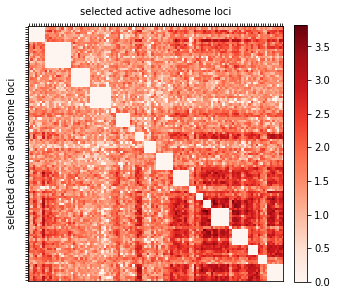

In [20]:
# Plot HiC matrices: all adhesome loci
lu.plot_heatmap(contacts_df_cd3t_adhesome,
                ['' for _ in selected_adhesome_loci], ['' for _ in selected_adhesome_loci], 
                'selected active adhesome loci', 'selected active adhesome loci', 
                5, max_val, add_patches = [], cmap='Reds')

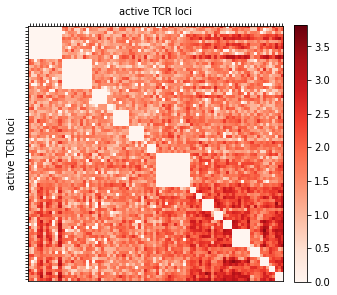

In [21]:
# Plot HiC matrices: all TCR loci
lu.plot_heatmap(contacts_df_cd3t_tcr,
                ['' for _ in selected_tcr_loci], ['' for _ in selected_tcr_loci], 
                'active TCR loci', 'active TCR loci', 
                5, max_val, add_patches = [], cmap='Reds')

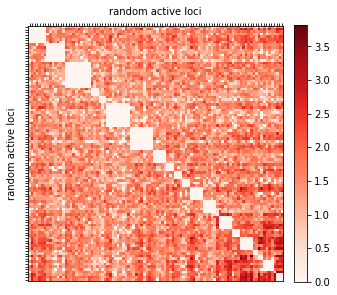

In [22]:
# Plot HiC matrices: all adhesome loci
lu.plot_heatmap(contacts_df_cd3t_random,
                ['' for _ in random_loci], ['' for _ in random_loci], 
                'random active loci', 'random active loci', 
                5, max_val, add_patches = [], cmap='Reds')

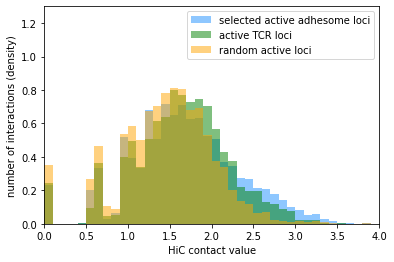

Wilcoxon Rank-Sums test (green vs blue):
RanksumsResult(statistic=1.1311283339849618, pvalue=0.258001080217531)
Wilcoxon Rank-Sums test (green vs orange):
RanksumsResult(statistic=13.8137524125431, pvalue=2.1057075528758402e-43)


In [23]:
# Compare HiC connections between the three groups
contacts_adhesome_ls = pickle.load(open(saving_dir+'contacts_ls_cd3t_adhesome.pkl', 'rb'))
contacts_tcr_ls = pickle.load(open(saving_dir+'contacts_ls_cd3t_tcr.pkl', 'rb'))
contacts_random_ls = pickle.load(open(saving_dir+'contacts_ls_cd3t_random.pkl', 'rb'))
plt.figure()
plt.hist(contacts_adhesome_ls, 
         bins=np.arange(0,4.5,0.1), density=True,
         color='dodgerblue', alpha=0.5, label='selected active adhesome loci')
plt.hist(contacts_tcr_ls, 
         bins=np.arange(0,4.5,0.1), density=True,
         color='green', alpha=0.5, label='active TCR loci')
plt.hist(contacts_random_ls, 
         bins=np.arange(0,4.5,0.1), density=True,
         color='orange', alpha=0.5, label='random active loci')
#plt.yscale('log')
plt.xlim(0,4)
plt.ylim(0,1.3)
plt.legend(loc='upper right')
plt.xlabel('HiC contact value')
plt.ylabel('number of interactions (density)')
plt.show()

print('Wilcoxon Rank-Sums test (green vs blue):')
print(ss.ranksums(contacts_adhesome_ls,
                  contacts_tcr_ls))
print('Wilcoxon Rank-Sums test (green vs orange):')
print(ss.ranksums(contacts_tcr_ls,
                  contacts_random_ls))

In [24]:
# Compare cluster strength to distribution of cluster strengths
cluster_genes = ['CAPN1', 'CFL1', 'MAPK8IP3', 'PKD1', 'STAT3', 'PIP5K1C']
cluster_genes = ['CD151', 'HRAS', 'PLEC', 'SHARPIN', 'SLC16A3']
cluster_loci = np.array(list(itertools.chain.from_iterable([gene2locus[g] for g in cluster_genes])))
cluster_loci_contact = contacts_df_cd3t_adhesome.loc[cluster_loci, cluster_loci]

KeyError: "['chr_11_loc_750000', 'chr_11_loc_500000', 'chr_8_loc_144750000', 'chr_8_loc_145000000'] not in index"

In [27]:
blacklist_dict

defaultdict(list,
            {2: {0,
              22250000,
              26000000,
              26250000,
              26500000,
              26750000,
              27000000,
              27250000,
              27500000,
              31750000,
              35250000,
              35750000,
              47750000,
              48250000,
              57250000,
              61750000,
              62000000,
              63250000,
              63500000,
              73500000,
              73750000,
              86750000,
              88500000,
              90250000,
              90500000,
              90750000,
              91000000,
              91250000,
              91500000,
              91750000,
              92000000,
              92250000,
              92500000,
              92750000,
              93000000,
              93250000,
              93500000,
              93750000,
              94000000,
              94250000,
              94500000,
  